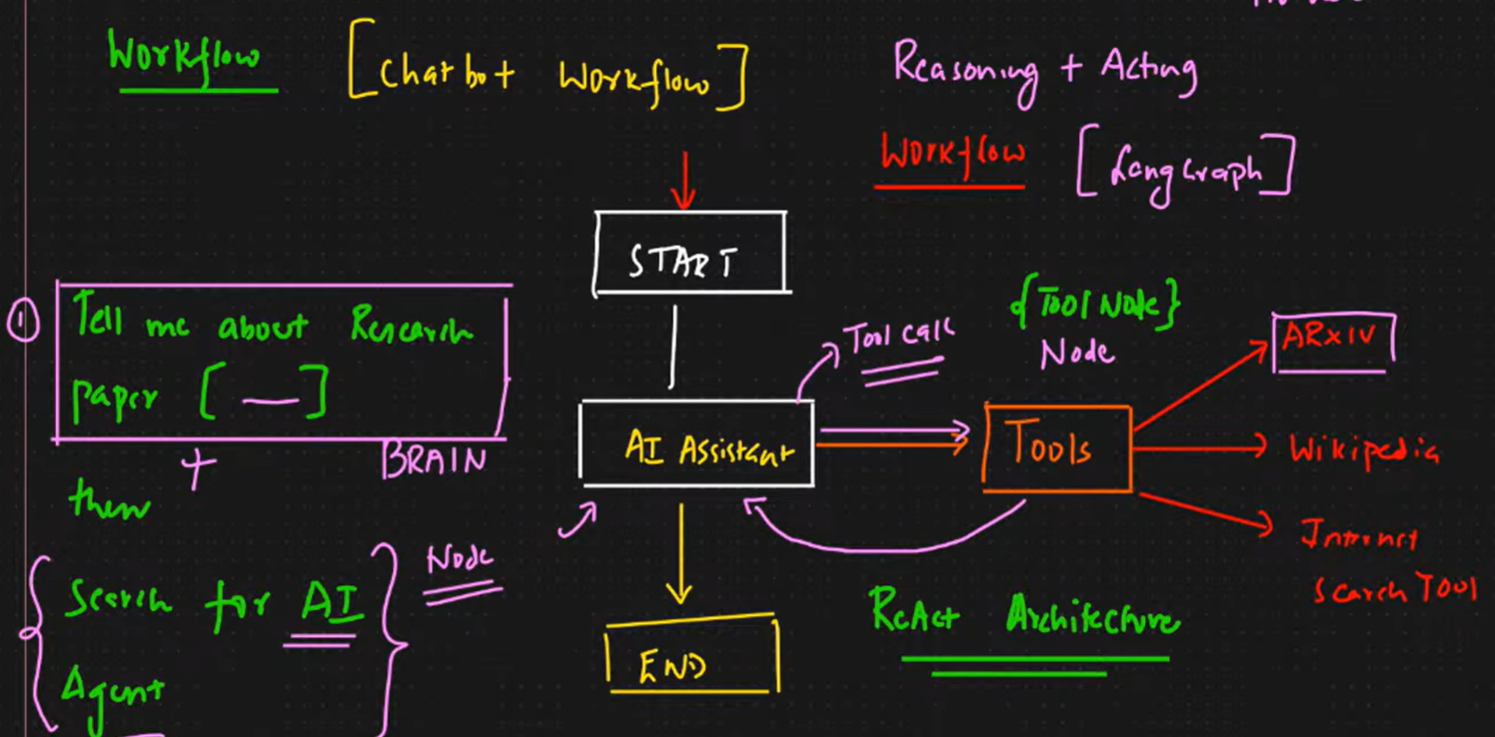

In [62]:
#tools

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [63]:
api_wrapper_arxiv= ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [64]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [65]:
api_wrapper_wiki= WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

Now tools are ready now we should integrate it

In [66]:
from dotenv import load_dotenv
load_dotenv() 

import os
os.environ["TAVILY_API_Key"]= os.getenv("TAVILY_API_Key")
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")

Create Tavily tool

In [67]:
# Tavily Search Tool

from langchain_community.tools.tavily_search import TavilySearchResults

tavily=TavilySearchResults()

In [68]:
tavily.invoke("Latest advancements in AI research")

[{'title': '8 Key AI Developments Shaping 2025',
  'url': 'https://ai.koombea.com/blog/key-ai-developments',
  'content': 'From powerful generative chatbots to AI-driven drug discovery, the latest AI trends and developments are creating opportunities and challenges that tech decision-makers can’t ignore. Staying current with artificial intelligence news is essential to understand how these rapid developments are shaping industries and redefining business strategies. In this article, we examine eight of the most impactful recent artificial intelligence developments. These range from cutting-edge solutions enhancing [...] ease. These advancements have been made possible by the exponential growth in computational power, which allows AI models to process and generate increasingly complex outputs in real time. Much of this computational capacity is driven by modern data centers, which are optimized to support the massive workloads required by today’s most advanced AI models. In some cases, 

Combine all the tools in the list

In [69]:
tools=[arxiv, wiki, tavily]

Initalize the LLM Model

In [70]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="qwen/qwen3-32b",
    temperature=0
)

response = llm.invoke("Explain gradient descent in simple words")
print(response.content)


<think>
Okay, so I need to explain gradient descent in simple words. Let me start by recalling what I know about it. Gradient descent is an optimization algorithm used in machine learning to minimize a function. But how do I break that down into simpler terms?

First, maybe use an analogy. I remember hearing about the mountain analogy. Imagine you're on a mountain and you want to get to the bottom. You can't see the path, so you take steps in the direction where the slope is steepest. That's gradient descent. Each step you take is determined by the steepness of the slope. The steeper the slope, the bigger the step you take. But you don't want to take too big of a step, or you might overshoot the minimum. So there's a balance there.

Wait, but how does this relate to machine learning? In machine learning, we have a model that makes predictions, and we want to adjust the model's parameters to reduce the error. The error is measured by a cost function. Gradient descent helps us find the p

Combine Tools with LLM

In [71]:
llm_with_tool=llm.bind_tools(tools=tools)

In [72]:
#Execute the call
llm_with_tool.invoke("What is the recent news about AI")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news about AI. I need to figure out which tool to use here. Let me check the available tools. There\'s arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is for academic papers, so maybe not the best choice for recent news. Wikipedia is good for general information but might not have the latest updates. The third tool, tavily_search_results_json, is described as a search engine optimized for current events. That sounds perfect for recent news.\n\nSo I should use tavily_search_results_json with the query "recent news about AI". Let me make sure the parameters are correct. The function requires a "query" parameter, which I\'ll set to "recent developments in AI 2023" to get the most up-to-date information. \n\nWait, the user just said "recent news about AI". Maybe I should use that exact phrase. But adding "2023" could help get more relevant results. Hmm, but the user didn\'t specif

The output say's it is a tool call and it is using tavily_search_result

WorkFlow

In [73]:
# State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

In [74]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

-> list[AnyMessage] meanse it will get all the messages which are system generated, AI generated, human message it will get appended and it is getting appended with functions called add_messages

-> add_messages is known as Reducers and it is appending the messages

In [75]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [76]:
# Node definitions
def tool_calling_llm(state:State):
    return{"messages": [llm_with_tool.invoke(state["messages"])]}

In [77]:
#Build Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

In [78]:
# Edges

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools", END)

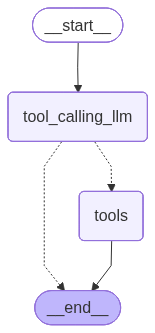

In [79]:
# Compile Graph
graph=builder.compile()

# Visualize Graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [81]:
messages= graph.invoke({"messages":"Tell me the difference between Agentic AI and AI Agents"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me the difference between Agentic AI and AI Agents
================================== Ai Message ==================================
Tool Calls:
  wikipedia (j3y3f51p0)
 Call ID: j3y3f51p0
  Args:
    query: AI agents
  wikipedia (wa623xe60)
 Call ID: wa623xe60
  Args:
    query: Agentic AI
  arxiv (fft5yx9k7)
 Call ID: fft5yx9k7
  Args:
    query: Agentic AI
================================= Tool Message =================================
Name: wikipedia

Page: Agentic AI
Summary: In the context of generative artificial intelligence, AI agents (also referred to as compound AI systems or agentic AI) are a class of intelligent agents distinguished by their ability to operate autonomously in complex environments. Agentic AI tools prioritize decision-making over content creation and do not require human prompts or continuous oversight.

Page: Manus (AI agent)
Summary: Manus (meaning "hand" in Latin) is an

In [82]:
messages= graph.invoke({"messages":"Hi how are you"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi how are you
================================== Ai Message ==================================

I'm an AI, so I don't have feelings, but I'm here to help! How can I assist you today?


Other graph

In [89]:
# Node definitions
def tool_calling_llm(state:State):
    return{"messages": [llm_with_tool.invoke(state["messages"])]}

#Build Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Edges

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

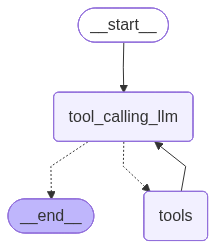

In [90]:
# Compile Graph
graph=builder.compile()

# Visualize Graph
display(Image(graph.get_graph().draw_mermaid_png()))